<a href="https://colab.research.google.com/github/siddiqui16/modeling_task/blob/main/TCS_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
 1. Create the training dataset based on the BMI business rules.
 2. Develop a model to predict BMI. The thinking process is more important than the actual model or model metrics.
 3. Write steps to operationalize the model.

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load Data
 * We are first going to load and explore the data.
 * Except for column `IssueDate`, there are no missing values.
   * At the moment `IssueDate` appears to be an unnecessary column. However, the date when an application is made may carry some significance. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   AppID       100 non-null    int64  
 1   Ins_Age     100 non-null    int64  
 2   Ins_Gender  100 non-null    object 
 3   Ht          100 non-null    int64  
 4   Wt          100 non-null    int64  
 5   IssueDate   0 non-null      float64
dtypes: float64(1), int64(4), object(1)
memory usage: 4.8+ KB


,AppID,Ins_Age,Ins_Gender,Ht,Wt,IssueDate
0,56372,31,Male,510,185,NaN
1,34565,35,Male,510,205,NaN
2,57732,45,Female,510,125,NaN
3,87324,38,Male,503,175,NaN
4,12323,39,Female,600,252,NaN


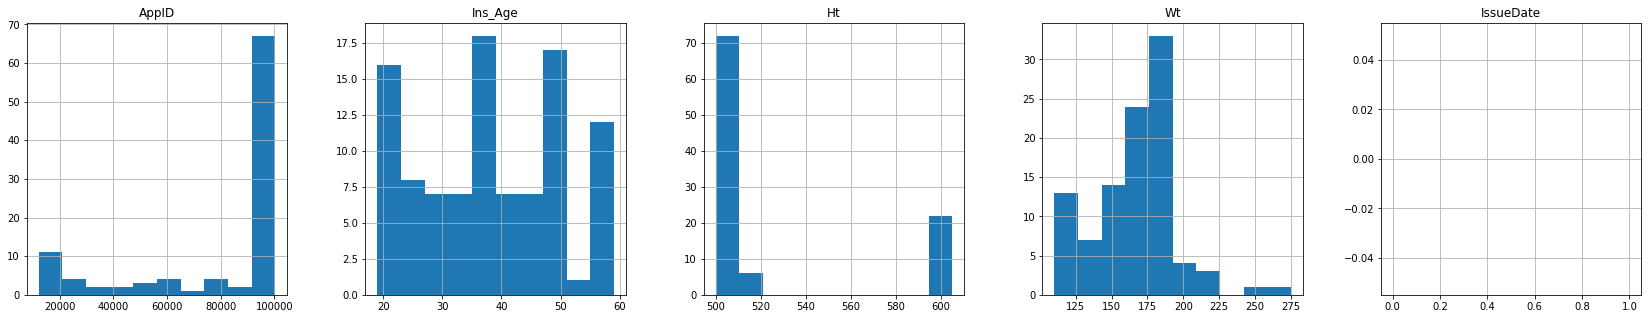

In [2]:
df_0 = pd.read_csv("tcs.csv")
df_0.info()
res = df_0.hist(layout=(1,df_0.shape[1]), figsize=(35,5))
df_0.head()

# Preprocess

## Transform Data
 * From the description file, we know that the units for `Ht` and `Wt` are not in metric system. We would create new columns with metric units.
 * We are going to store transfomation config as list of tuple:
    1.   col_old
    2.   col_new 
    3.   func_transform_old_to_new 
    4.   func_transform_new_to_old (to convert the data back into original format)


**Note:**
It's important to modularise all steps of preprocessing as a versioned script. For larger projects it would be advisable to create small python pacakges for all the transformation that are done. This is to make sure that the models learned on this transformed data can be used to inference/score live data using exactly the same transformations.


In [3]:
# Transformations
UNIT_INCHES_TO_METERS = 0.0254
UNIT_POUNDS_TO_KGS = 0.453592

# Transformation
# Format: (<col_old>, <col_new>, func_transform_old_to_new, transform_new_to_old)
col_transformations = [
    ("AppID", "app_id", 
     lambda x: x, 
     lambda x: x),
    ("IssueDate", "app_date", 
     lambda x: x, 
     lambda x: x),
    ("Ins_Age", "age", 
     lambda x: x, 
     lambda x: x),
    ("Ins_Gender", "is_female", 
     lambda x: 1 if x=="Female" else 0, 
     lambda x: "Female" if x==1 else "Male"),
    ("Ht", "height", 
     lambda x: (x//100*12+x%100)*UNIT_INCHES_TO_METERS, 
     lambda x: (x/UNIT_INCHES_TO_METERS)//12*100 + (x/UNIT_INCHES_TO_METERS)%12),
    ("Wt", "weight", 
     lambda x: x*UNIT_POUNDS_TO_KGS, 
     lambda x: x/UNIT_POUNDS_TO_KGS)
]

def apply_col_transformations(df, transform, forward=True, drop_columns=True):
    df = df.copy()
    cols_to_drop = []
    for c_old, c_new, ft_forward, ft_backward in transform:
        if forward:
            df[c_new] = df[c_old].apply(ft_forward)
            cols_to_drop += [c_old]
        else:
            df[c_old] = df[c_new].apply(ft_backward)
            cols_to_drop += [c_new]
    if drop_columns:
        print("Dropping", cols_to_drop)
        df.drop(cols_to_drop, axis=1, inplace=True)
    return df

df_1 = apply_col_transformations(df_0, col_transformations)
df_1.head()

Dropping ['AppID', 'IssueDate', 'Ins_Age', 'Ins_Gender', 'Ht', 'Wt']


,app_id,app_date,age,is_female,height,weight
0,56372,NaN,31,0,1.7780,83.914520
1,34565,NaN,35,0,1.7780,92.986360
2,57732,NaN,45,1,1.7780,56.699000
3,87324,NaN,38,0,1.6002,79.378600
4,12323,NaN,39,1,1.8288,114.305184


## Compute BMI

In [4]:
def compute_bmi(df):
    df = df.copy()
    df["bmi"] = df.apply(lambda x: x["weight"]/x["height"], axis=1)
    return df
df_1 = compute_bmi(df_1)
df_1.head()

,app_id,app_date,age,is_female,height,weight,bmi
0,56372,NaN,31,0,1.7780,83.914520,47.196018
1,34565,NaN,35,0,1.7780,92.986360,52.298290
2,57732,NaN,45,1,1.7780,56.699000,31.889201
3,87324,NaN,38,0,1.6002,79.378600,49.605424
4,12323,NaN,39,1,1.8288,114.305184,62.502835


## Add Business Rules
 * We will add business rules to the dataset by appending two additional columns.
   * `quote` (Unit Dollars)
   * `reason`

In [5]:
# Default: quote = 500, reason = "BMI is in right range"

def compute_business_rules_rowwise(x):
    if 18<=x["age"]<=39 and (x["bmi"]<17.49 or x["bmi"]>38.5):
        # 1. If Age is between 18 and 39 and BMI less than 17.49 or greater than 38.5, provide quote as 750 USD
        x["quote"] = 750
        x["reason"] = "Age is between 18 to 39 and 'BMI' is either less than 17.49 or greater than 38.5"
    elif 40<=x["age"]<=59 and (x["bmi"]<18.49 or x["bmi"]>38.5):
        # 2. If Age is between 40 and 59 and BMI less than 18.49 or greater than 38.5, provide quote as 1000 USD.
        x["quote"] = 1000
        x["reason"] = "Age is between 40 to 59 and 'BMI' is either less than 18.49 or greater then 38.5"
    elif  60<=x["age"] and (x["bmi"]<18.49 or x["bmi"]>38.5):
        x["quote"] = 2000
        x["reason"] = "Age is greater than 60 and 'BMI' is either less than 18.49 or greater than 38.5"
    if x["is_female"]:
        x["quote"]*= 0.9
    return x

def compute_business_rules(df):
    df = df.copy()
    df["quote"] = 500
    df["reason"] = "BMI is in right range"
    df = df.apply(lambda x: compute_business_rules_rowwise(x), axis=1)
    return df

df_2 = compute_business_rules(df_1)
#df_2["quote"] = df_2["quote"].apply(lambda x: f"{int(x)}")
df_2.head()

,app_id,app_date,age,is_female,height,weight,bmi,quote,reason
0,56372,NaN,31,0,1.7780,83.914520,47.196018,750.0,Age is between 18 to 39 and 'BMI' is either le...
1,34565,NaN,35,0,1.7780,92.986360,52.298290,750.0,Age is between 18 to 39 and 'BMI' is either le...
2,57732,NaN,45,1,1.7780,56.699000,31.889201,450.0,BMI is in right range
3,87324,NaN,38,0,1.6002,79.378600,49.605424,750.0,Age is between 18 to 39 and 'BMI' is either le...
4,12323,NaN,39,1,1.8288,114.305184,62.502835,675.0,Age is between 18 to 39 and 'BMI' is either le...


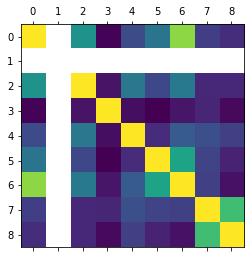

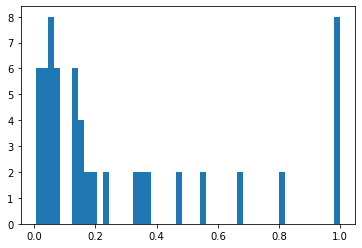

In [6]:
df_corr = df_2.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
arr_corr = np.array(df_corr).reshape(-1,1)
plt.matshow(df_corr)
plt.show()
res = plt.hist(np.abs(arr_corr), bins=50)

## Check if app_id is unique
 * The data frame contains duplicate app_ids.
 * The column values are not identical for the duplicated ids
 * The duplicate might have been caused by the function that annonymises the `app_id`
 * This should be clarified with the data science team.
 * For now, we can go forward with the assumption of something like hash collision.
 * The id column in this dataset doesnt carry any meaning other than being an identifier and can be removed  

In [7]:
df_2_app_id_dups = df_2.groupby("app_id").agg(count=pd.NamedAgg(column="app_id", aggfunc=len)).query("count > 1")
pd.merge(df_2_app_id_dups, df_2, on="app_id")

,app_id,count,app_date,age,is_female,height,weight,bmi,quote,reason
0,93077,2,NaN,36,0,1.8542,54.884632,29.600168,500.0,BMI is in right range
1,93077,2,NaN,50,0,1.7780,54.884632,30.868747,500.0,BMI is in right range
2,93587,2,NaN,19,0,1.5240,65.770840,43.156719,750.0,Age is between 18 to 39 and 'BMI' is either le...
3,93587,2,NaN,19,0,1.8542,81.646560,44.033308,750.0,Age is between 18 to 39 and 'BMI' is either le...
4,99497,2,NaN,36,0,1.5748,63.502880,40.324409,750.0,Age is between 18 to 39 and 'BMI' is either le...
5,99497,2,NaN,38,0,1.6002,63.502880,39.684339,750.0,Age is between 18 to 39 and 'BMI' is either le...
6,99511,2,NaN,28,0,1.6764,81.646560,48.703508,750.0,Age is between 18 to 39 and 'BMI' is either le...
7,99511,2,NaN,35,0,1.7780,124.737800,70.156243,750.0,Age is between 18 to 39 and 'BMI' is either le...
8,99513,2,NaN,59,0,1.8542,81.646560,44.033308,1000.0,Age is between 40 to 59 and 'BMI' is either le...
9,99513,2,NaN,55,0,1.9558,81.646560,41.745864,1000.0,Age is between 40 to 59 and 'BMI' is either le...


## Drop Columns
 * The column `app_date` is null an can be removed

In [8]:
cols_to_drop = ["app_id", "app_date", "reason"]

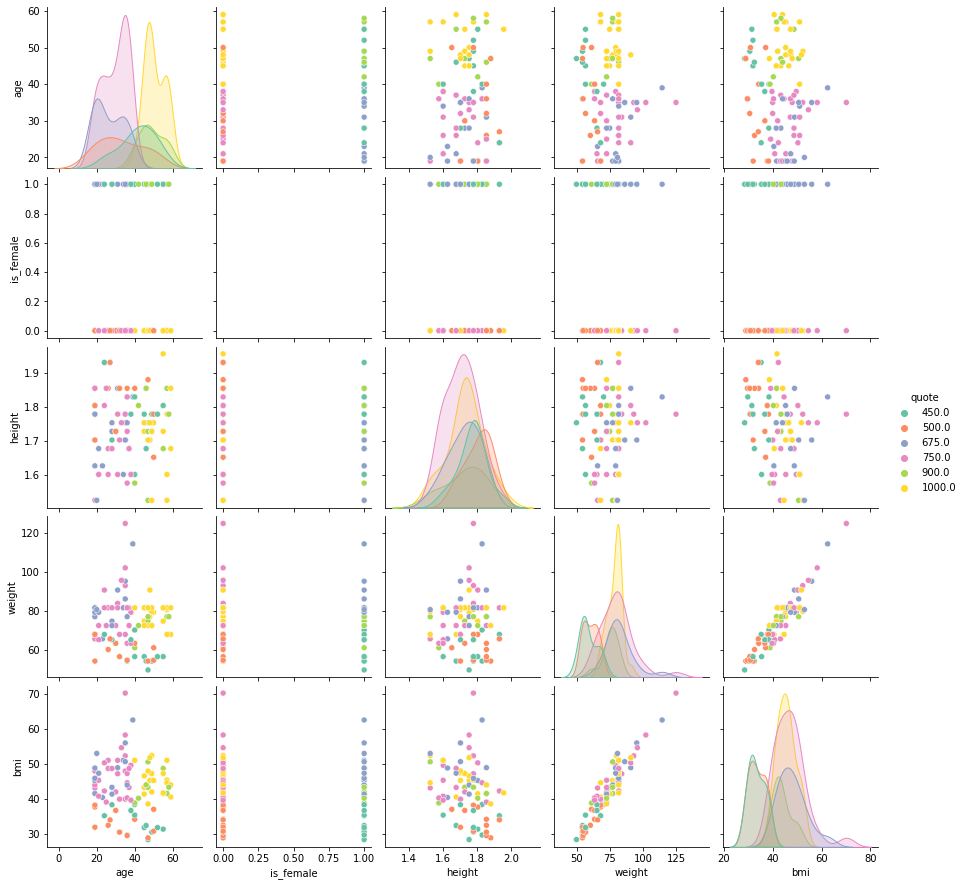

In [9]:
sns.pairplot(df_2.drop(cols_to_drop, axis=1), hue="quote", palette="Set2", height=2.5)

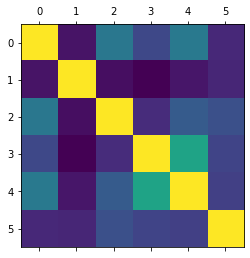

,age,is_female,height,weight,bmi,quote
age,1.000000,-0.015839,0.352808,0.161867,0.363299,0.050625
is_female,-0.015839,1.000000,-0.030004,-0.070749,-0.004859,0.045689
height,0.352808,-0.030004,1.000000,0.065055,0.237957,0.189813
weight,0.161867,-0.070749,0.065055,1.000000,0.552441,0.147251
bmi,0.363299,-0.004859,0.237957,0.552441,1.000000,0.133542
quote,0.050625,0.045689,0.189813,0.147251,0.133542,1.000000


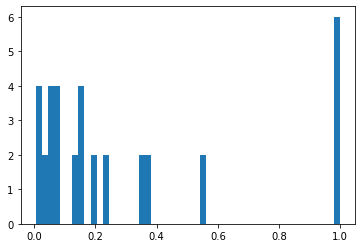

In [10]:
df_corr = df_2.drop(cols_to_drop, axis=1).apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)

arr_corr = np.array(df_corr).reshape(-1,1)
plt.matshow(df_corr)
plt.show()
res = plt.hist(np.abs(arr_corr), bins=50)
df_corr

## Finalise the training dataset

In [11]:
def drop_useless_columns(df, cols):
    for c in cols:
        if c in df.columns:
            df = df.drop([c], axis=1)
    return df
df_3 = drop_useless_columns(df_2, cols_to_drop)
df_3.info()
df_3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        100 non-null    int64  
 1   is_female  100 non-null    int64  
 2   height     100 non-null    float64
 3   weight     100 non-null    float64
 4   bmi        100 non-null    float64
 5   quote      100 non-null    float64
dtypes: float64(4), int64(2)
memory usage: 4.8 KB


,age,is_female,height,weight,bmi,quote
0,31,0,1.7780,83.914520,47.196018,750.0
1,35,0,1.7780,92.986360,52.298290,750.0
2,45,1,1.7780,56.699000,31.889201,450.0
3,38,0,1.6002,79.378600,49.605424,750.0
4,39,1,1.8288,114.305184,62.502835,675.0
...,...,...,...,...,...,...
95,35,0,1.7780,124.737800,70.156243,750.0
96,27,0,1.9304,65.770840,34.071094,500.0
97,35,1,1.7018,86.182480,50.641956,675.0
98,38,1,1.7780,65.317248,36.736360,450.0


# Modeling 

### **Observations**
 * The first task of creation of the dataset is completed `df_3`.
 * The second task asks to develop a model to predict BMI. 
 * This is confusing. BMI can be determined if the weight and height are known.
 * The **learning task** for a life insurance company should be **to estimate the premium**, i.e., `quote`, for each applicant based on his physical attributes.

Here we proceed with the assumption that customer has mis-specified the learning task. 

Our learning task is to quote a preium for the customer given his attributes.
We will use `quote` as our target attribute.
 * Its a numeric attribute and regression seems to be the obvious choice.
   * To measure the performace of the model we will use RMSE as a validation metric
 * However, the values in `quote` are sort of discrete. If the the insurance company wants to offer only these premiums and treat them as classes/level, this then becomes a multi class problem.
   * To measure the the performance of the model when `quote` is considered as ccategorical class, we can use balance accuracy. 

We will treat this hear as **classification** problem.


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, mean_squared_error, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Normalizer, StandardScaler


## Split dataset into (train, validate) and test.

In [13]:
cols_x = ["age", "height", "weight", "bmi", "is_female"]
cols_y = ["quote"]

def split_data(df, x_cols, y_cols, test_split=0.33):
    X_train_, X_test, y_train_, y_test = train_test_split(df[cols_x], df[cols_y], test_size=test_split, random_state=19)
    X_train, X_validate, y_train, y_validate = train_test_split(X_train_, y_train_, test_size=test_split, random_state=19)
    return X_train, X_validate, X_test, y_train, y_validate, y_test

X_train, X_validate, X_test, y_train, y_validate, y_test = split_data(df_3, cols_x, cols_y)

print("train   ", X_train.shape, y_train.shape)
print("validate", X_validate.shape, y_validate.shape)
print("test    ", X_test.shape, y_test.shape)

train    (44, 5) (44, 1)
validate (23, 5) (23, 1)
test     (33, 5) (33, 1)


In [14]:
def learn_normalise_model(x):
    return StandardScaler().fit(x)

def normalise_data(X_train, X_validate, X_test):
    model_normalise = learn_normalise_model(X_train)
    X_train_normalized = model_normalise.transform(X_train)
    X_validate_normalized = model_normalise.transform(X_validate)
    X_test_normalized = model_normalise.transform(X_test)
    return X_train_normalized, X_validate_normalized, X_test_normalized, model_normalise

X_train_normalized, X_validate_normalized, X_test_normalized, model_normalise = normalise_data(X_train, X_validate, X_test)
X_train_normalized

array([[-1.16504766, -0.41190007,  0.55364246,  0.69642824,  1.20185043],
       [-0.2430675 ,  1.30249482,  1.65293255,  0.94738593,  1.20185043],
       [-1.34944369,  0.56775415,  0.77350048,  0.46858397,  1.20185043],
       [ 0.21792258,  0.07792704,  0.77350048,  0.6837501 , -0.83205029],
       [ 0.40231862,  0.56775415, -0.80947725, -0.99454576,  1.20185043],
       [ 2.24627894,  0.56775415,  0.33378444,  0.06215904,  1.20185043],
       [-1.25724568, -1.8813814 ,  0.68555727,  1.59302626,  1.20185043],
       [ 1.23210076,  1.54740837, -0.10593159, -0.69576852, -0.83205029],
       [-0.51966155,  0.07792704,  0.11392643,  0.05618221,  1.20185043],
       [ 0.40231862, -1.14664074, -0.98536366, -0.52489918, -0.83205029],
       [ 0.58671465, -1.39155429, -1.20522168, -0.6523622 ,  1.20185043],
       [ 1.23210076,  0.07792704,  0.11392643,  0.05618221,  1.20185043],
       [-0.15086948, -0.16698652, -0.54564763, -0.47771884, -0.83205029],
       [ 0.58671465, -1.14664074, -1.6

## Classification
* We will try multiple algorithms, 

In [16]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

def train_model_classification(model, name=None, X_train=None, y_train=None, X_test=None, y_test=None, f_train=True, verbose=False):
    if not name:
        name = str(model)[:10]
    m_train = 0.0
    if f_train:
        model.fit(X_train, y_train.values.ravel())
        y_train_hat = model.predict(X_train)
        m_train = balanced_accuracy_score(y_train, y_train_hat)
    y_test_hat = model.predict(X_test)
    m_test  = balanced_accuracy_score(y_test, y_test_hat)
    if verbose:
        print("%0.4f - %0.4f" % (m_train, m_test), name)
    #print(m_test)
    return m_train, m_test, model

algos = {
    "DT ": DecisionTreeClassifier(max_depth=2),
    "GridDT": GridSearchCV(DecisionTreeClassifier(), {'criterion':['gini','entropy'],'max_depth':[2,3,4], 'min_samples_leaf':[3,4]}),
    "LR": LogisticRegression(max_iter=50),
    "GridLR": GridSearchCV(LogisticRegression(), {'penalty':['l2', 'none'], "max_iter":[50]}),
    "RFC": RandomForestClassifier(max_depth=3),
    "AdaDT":AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=100, learning_rate=0.5),
    "GridAdaDT": GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(max_depth=4)), {'learning_rate':[0.1,0.5,1,2],'n_estimators':[10,50,100,200]}),
 }

learned_models = {}
learned_models_perf = {}

for i in range(10):
    print(i, "-"*80)
    X_train, X_validate, X_test, y_train, y_validate, y_test = split_data(df_3, cols_x, cols_y, test_split = 0.33)
    X_train_normalized, X_validate_normalized, X_test_normalized, model_normalise = normalise_data(X_train, X_validate, X_test)

    print("Validate", "-"*30)
    for name in algos:
        m_train, m_test, model = train_model_classification(algos[name], name=name, X_train=X_train_normalized, y_train=y_train, X_test=X_validate_normalized, y_test=y_validate)
        learned_models[name] = model

    print("Test", "-"*30)
    for name in learned_models:
        m_train, m_test, model = train_model_classification(learned_models[name], name=name, X_test=X_test_normalized, y_test=y_test, f_train=False)
        if name not in learned_models_perf:
            learned_models_perf[name] = []
        learned_models_perf[name].append(m_test)
learned_models_perf
df_perf = pd.DataFrame(learned_models_perf).melt()
df_perf.columns = ["model", "balanced_accuracy_score"]


0 --------------------------------------------------------------------------------
Validate ------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


Test ------------------------------
1 --------------------------------------------------------------------------------
Validate ------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


Test ------------------------------
2 --------------------------------------------------------------------------------
Validate ------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


Test ------------------------------
3 --------------------------------------------------------------------------------
Validate ------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


Test ------------------------------
4 --------------------------------------------------------------------------------
Validate ------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


Test ------------------------------
5 --------------------------------------------------------------------------------
Validate ------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


Test ------------------------------
6 --------------------------------------------------------------------------------
Validate ------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


Test ------------------------------
7 --------------------------------------------------------------------------------
Validate ------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


Test ------------------------------
8 --------------------------------------------------------------------------------
Validate ------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


Test ------------------------------
9 --------------------------------------------------------------------------------
Validate ------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


Test ------------------------------


## Result
 * The dataset is rather and all models show a comparable perf.

### Performance Plots

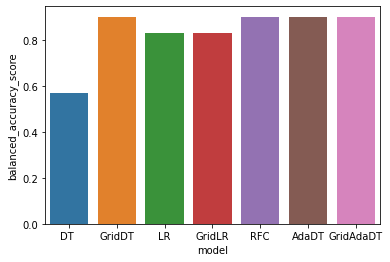

In [18]:
res = sns.barplot(x="model", y="balanced_accuracy_score", data=df_perf)

### Performance based on amount of training examples

In [20]:
algos = {
    "RFC": RandomForestClassifier(max_depth=3),
 }

learned_models_amount = {}
learned_models_amount_perf = {}

for i in range(2,19):
    si = i/20.0
    print(i, "-"*80)
    X_train, X_validate, X_test, y_train, y_validate, y_test = split_data(df_3, cols_x, cols_y, test_split = si )
    X_train_normalized, X_validate_normalized, X_test_normalized, _ = normalise_data(X_train, X_validate, X_test)

    #print("Validate", "-"*30)
    for name in algos:
        m_train, m_test, model = train_model_classification(algos[name], name=name, X_train=X_train_normalized, y_train=y_train, X_test=X_validate_normalized, y_test=y_validate)
        learned_models_amount[name] = model

    #print("Test", "-"*30)
    for name in learned_models_amount:
        m_train, m_test, model = train_model_classification(learned_models_amount[name], name=name, X_test=X_test_normalized, y_test=y_test, f_train=False)
        if name not in learned_models_amount_perf:
            learned_models_amount_perf[name] = []
            learned_models_amount_perf["split"] = []
        learned_models_amount_perf[name].append(m_test)
        learned_models_amount_perf["split"].append(1-si)
learned_models_amount_perf
df_perf = pd.DataFrame(learned_models_amount_perf)
df_perf.columns = ["balanced_accuracy_score","split"]
#df_perf

2 --------------------------------------------------------------------------------
3 --------------------------------------------------------------------------------
4 --------------------------------------------------------------------------------
5 --------------------------------------------------------------------------------
6 --------------------------------------------------------------------------------
7 --------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


8 --------------------------------------------------------------------------------
9 --------------------------------------------------------------------------------
10 --------------------------------------------------------------------------------
11 --------------------------------------------------------------------------------
12 --------------------------------------------------------------------------------
13 --------------------------------------------------------------------------------
14 --------------------------------------------------------------------------------
15 --------------------------------------------------------------------------------
16 --------------------------------------------------------------------------------
17 --------------------------------------------------------------------------------
18 --------------------------------------------------------------------------------


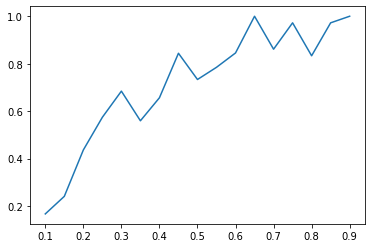

In [21]:
plt.plot(df_perf["split"],df_perf["balanced_accuracy_score"])

# Operationalise

* We have modularised our code and preparing a dataset for scoring can be done without any hassle. 
    * The function `preprocess()` takes care of all the required data transformation.
* In the following we will simply load all the data and select one of our model to score it with.

**Note**
* Ideally the models would be deployed as RestAPIs. 
* The data would be sent as json
* The above preocess would be applied and result would be sent back
* Later depending on the amount of data to be scored, precision of the model, and frequency of retraining would dictate what models to choose.

In [22]:
df = pd.read_csv("tcs.csv")

def preprocess(df):
    df = apply_col_transformations(df, col_transformations)
    df = compute_bmi(df)
    df = drop_useless_columns(df, cols_to_drop)
    df = compute_business_rules(df)
    df[cols_x] = pd.DataFrame(model_normalise.transform(df[cols_x]))
    return df
df = preprocess(df)
df.info()
df = df.sample(50)

Dropping ['AppID', 'IssueDate', 'Ins_Age', 'Ins_Gender', 'Ht', 'Wt']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        100 non-null    float64
 1   is_female  100 non-null    float64
 2   height     100 non-null    float64
 3   weight     100 non-null    float64
 4   bmi        100 non-null    float64
 5   quote      100 non-null    float64
 6   reason     100 non-null    object 
dtypes: float64(6), object(1)
memory usage: 5.6+ KB


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names

(0.0, 1.0)

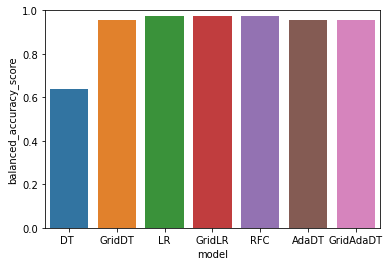

In [23]:
perf = {}
for name in learned_models:
    model = learned_models[name]
    df[name] = model.predict(df[cols_x])
    m = balanced_accuracy_score(df["quote"], df[name])
    #print(df[name], df["quote"])
    #print(name, m)
    perf[name] = [m]

df_perf = pd.DataFrame(perf).melt()
df_perf.columns = ["model", "balanced_accuracy_score"]
res = sns.barplot(x="model", y="balanced_accuracy_score", data=df_perf)
plt.ylim(0, 1)

# Appendix

## Regression
 * Before we learn the model, we have to normalise our datasets

### Learn model to normalise the dataset.
 * We will c
 * We will normalise all our datasets (train, validate, test) based only on train dataset.
   * For this we will learn a Normalizer model

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

def train_model_regression(model, name=None, X_train=None, y_train=None, X_test=None, y_test=None, f_train=True):
    if not name:
        name = str(model)[:10]
    m_train = 0.0
    if f_train:
        model.fit(X_train, np.array(y_train))
        y_train_hat = model.predict(X_train)
        m_train = mean_squared_error(y_train, y_train_hat)
    y_test_hat = model.predict(X_test)
    m_test  = mean_squared_error(y_test, y_test_hat)
    print("%0.4f - %0.4f" % (m_train, m_test), name)
    return m_train, m_test, model

algos = {
    "LR ": LinearRegression(),
    "GBR": GradientBoostingRegressor(),
    "XGB": XGBRegressor(),
    "RFR": RandomForestRegressor()
}

learned_models_regression = {}

for name in algos:
    m_train, m_test, model = train_model_regression(algos[name], name=name, X_train=X_train_normalized, y_train=y_train, X_test=X_validate_normalized, y_test=y_validate)
    learned_models_regression[name] = model

In [ ]:
for name in learned_models_regression:
    train_model_regression(learned_models_regression[name], name=name, X_test=X_test_normalized, y_test=y_test, f_train=False)